In [1]:
from pathlib import Path

data_dir = Path('rps')
image_count = len(list(data_dir.glob('*/*.png')))
print('Image Count : ', image_count)

Image Count :  2520


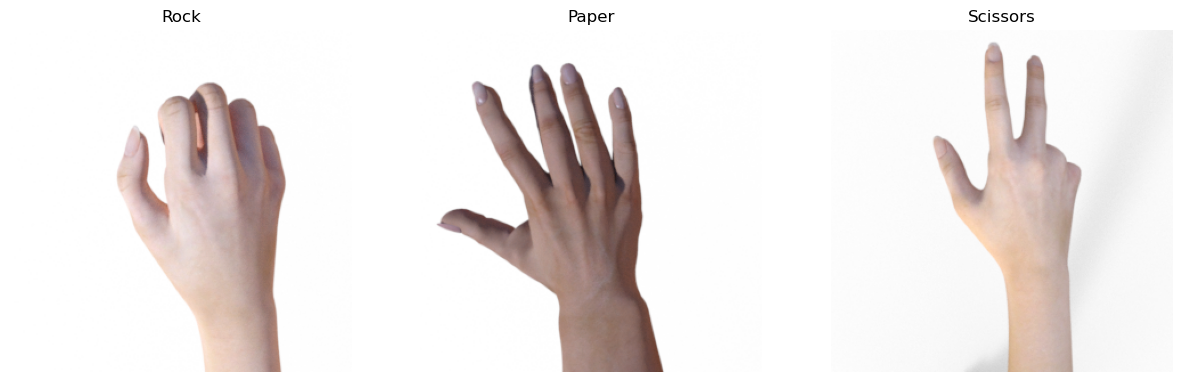

In [2]:
import random
import cv2
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 10))

image = cv2.imread('rps/rock/rock01-000.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax[0].imshow(image)
ax[0].set_title("Rock")
ax[0].axis("Off")

image = cv2.imread('rps/paper/paper01-080.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax[1].imshow(image)
ax[1].set_title("Paper")
ax[1].axis("Off")

image = cv2.imread('rps/scissors/scissors01-000.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax[2].imshow(image)
ax[2].set_title("Scissors")
ax[2].axis("Off")

plt.show()

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_height = 224
img_width = 224

train_data = image_dataset_from_directory(data_dir, seed=40, image_size=(img_height, img_width), validation_split=0.7, subset='training')

Found 2520 files belonging to 3 classes.
Using 756 files for training.


In [4]:
val_data = image_dataset_from_directory(data_dir, seed=40, image_size=(img_height, img_width), validation_split=0.25, subset='validation')

Found 2520 files belonging to 3 classes.
Using 630 files for validation.


In [5]:
test_data = image_dataset_from_directory(data_dir, seed=40, image_size=(img_height, img_width), validation_split=0.05, subset='validation')

Found 2520 files belonging to 3 classes.
Using 126 files for validation.


In [6]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Define your data augmentation layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.3),
    RandomContrast([0.5, 1.5])
])

train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))

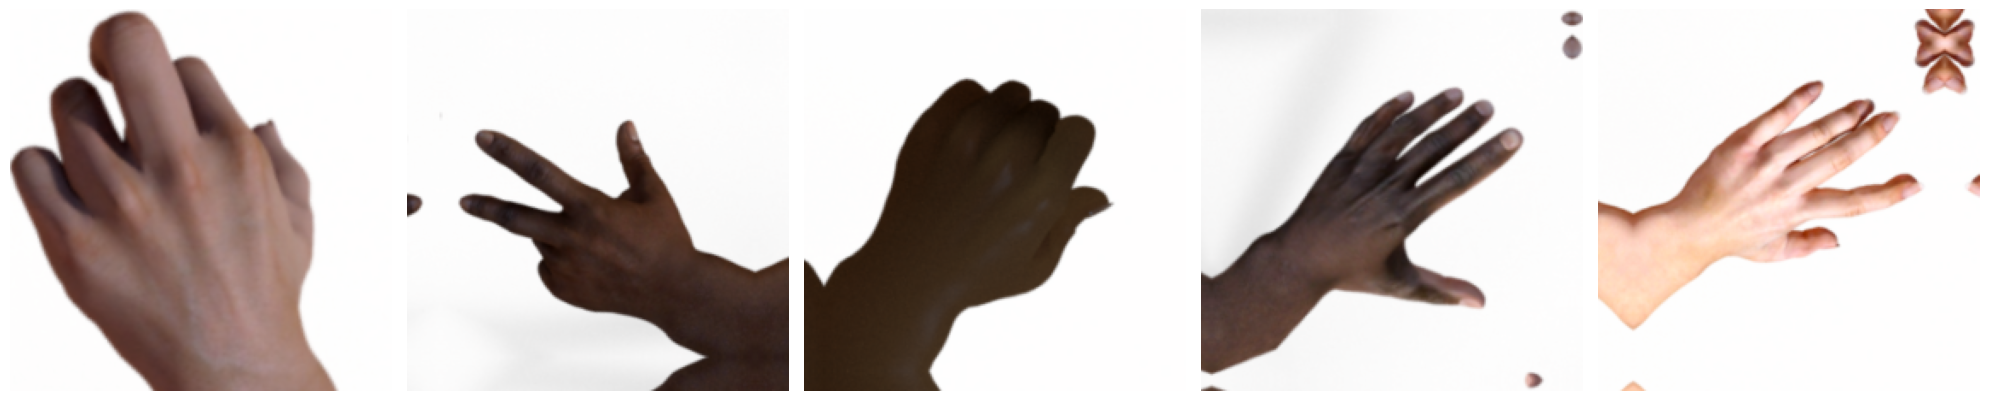

In [7]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # Rescale the images (if needed)
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Take one batch of images from the dataset and plot
for images, _ in train_data.take(1):
    plot_images(images[:5].numpy())

In [8]:
from tensorflow.keras.applications import EfficientNetV2B0

base_model = EfficientNetV2B0(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D

model=Sequential(name='EfficientNetV2B0')
model.add(base_model)
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

model.summary()

Model: "EfficientNetV2B0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 1280)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 1280)        0         
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 batch_normalization (Batch  (None, 11520)             46080     
 Normalization)                                                  
                                                  

In [10]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [11]:
with tf.device('/device:GPU:0'):
    history = model.fit(train_data,validation_data=val_data, epochs = 20, batch_size=128, use_multiprocessing=False)

Epoch 1/20
24/24 [==============================] - 42s 2s/step - loss: 1.0302 - accuracy: 0.6984 - val_loss: 0.6648 - val_accuracy: 0.8937
Epoch 2/20
24/24 [==============================] - 38s 2s/step - loss: 0.1517 - accuracy: 0.9709 - val_loss: 0.0058 - val_accuracy: 0.9968
Epoch 3/20
24/24 [==============================] - 39s 2s/step - loss: 0.0939 - accuracy: 0.9788 - val_loss: 0.0112 - val_accuracy: 0.9952
Epoch 4/20
24/24 [==============================] - 39s 2s/step - loss: 0.0808 - accuracy: 0.9828 - val_loss: 0.0063 - val_accuracy: 0.9984
Epoch 5/20
24/24 [==============================] - 40s 2s/step - loss: 0.0949 - accuracy: 0.9788 - val_loss: 0.0105 - val_accuracy: 0.9968
Epoch 6/20
24/24 [==============================] - 40s 2s/step - loss: 0.0864 - accuracy: 0.9841 - val_loss: 0.0159 - val_accuracy: 0.9952
Epoch 7/20
24/24 [==============================] - 40s 2s/step - loss: 0.0500 - accuracy: 0.9881 - val_loss: 0.0147 - val_accuracy: 0.9968
Epoch 8/20
24/24 [==

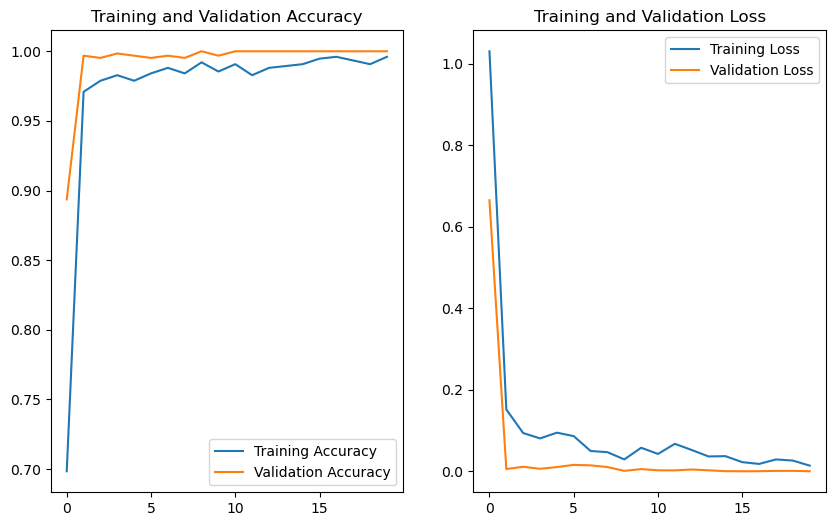

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
import numpy as np

predictions = model.predict(test_data)

y_pred = []
y_true = []

for image_batch, label_batch in test_data:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 883ms/step


In [14]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00        47

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



In [16]:
model.save('rps.h5')

/Users/athena/mlenv/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
